# Madagascar End-of-Season AA Assessment of Season 2023-24

Author - Nitin Magima

Date - March 2024

Version - 1.0


## Introduction and Objectives

### Purpose
The Jupyter Notebook aims to do a post-assessment of drought in Madagascar during the relevant seasons such as October-November-December (OND) and December-January-February (DJF).

### Audience
Tailored for Madagascar government officials in agriculture, water resources, and disaster management sectors.

### Objectives
To provide an in-depth analysis of drought conditions during OND and DJF, historical drought patterns in these months, and predictive insights for future OND seasons.

### Summary
The jupyter notebook uses VIIRS product #13, Gridded Vegetation Indices (VNP13 Level 3 suite). The level 3 gridded vegetation indices are standard products designed to extend the significant VI time series derived from AVHRR and MODIS (Huete et al. 2002). The level 3 spatial and temporal gridded vegetation index products are composites of daily surface reflectances. They are generated at 500m, 1km, and 0.05o (~5.6km) every 8 days (quasi), 16 days, and calendar month. 

The standard Normalized Difference Vegetation Index (NDVI), is referred to as the “continuity index” to the existing NOAA-AVHRR and MODIS-derived NDVI. At the time of S-NPP launch S-NPP VIIRS VI User Guide-V2.1.1 8  (2011), there was nearly a 30-year NDVI record from AVHRR and MODIS (1981- and 2000-). VIIRS NDVI will extend this long-term data record for use in operational monitoring studies.

The Enhanced Vegetation Index (EVI) was developed to optimize the vegetation signal with improved sensitivity in high biomass regions and improved vegetation monitoring through a de-coupling of the canopy background signal and a reduction in atmosphere influences (Huete et al. 1997; Huete et al. 2002). 

The Standardized Precipitation Index (SPI) developed by McKee et al. (1993) describes the probability of variation from the normal precipitation over multiple years of data, on a monthly (or multiple months) time step. The SPI is calculated by taking the precipitation of the pixel i during timeframe j of year k minus the mean of pixel i during timeframe j over n years, divided by the standard deviation of pixel i during timeframe j over n years.

The jupyter notebook creates a standardized precipitation index (SPI) timeline based on daily CHIRPS data (since 1981). The SPI is used as it highlights the difference to the mean precipitation during a given time and therefore provides information about drought-like conditions. The script will be executed within Google Earth Engine and will work on two independent SPI calculations. 

The first calculation deals with the "common" SPI, which is calculated on an n-months basis. A SPI, which is calculated for one month usually refers to the description of "SPI-1", for six months "SPI-6" and so on. The second SPI calculation is based on MODIS capture dates. As MODIS (MOD13Q1.006) provides information about the vegetation, it might be useful to compare its vegetation indices with the SPI. Therefore a 16-day SPI is calculated, whose start date matches with MODIS's start date (if the user does not apply a 'shift').

As precipitation data is usually not normally distributed, especially when it comes to timeframes of 12 months or less, a transformation should be applied. The data is typically fitted to a gamma function, but not supported in the script. The resulting SPI values can therefore just be used as an estimator.

Google Earth Engine (GEE) is a web platform for cloud-based processing of remote sensing data on a large scale. The advantage lies in its remarkable computation speed as processing is outsourced to Google servers. The platform provides a variety of constantly updated datasets; no download of raw imagery is required. While it is free of charge, one still needs to activate access to Google Earth Engine with a valid Google account.


### DISCLAIMER

This is a set of scripts  shared for educational purposes only.  Anyone who uses this code or its
functionality or structure, assumes full liability and credits the author.

#### Map Disclaimer

The designations employed and the presentation of the material on this map do not imply the expression 
of any opinion whatsoever on the part of the author concerning the legal status of any country, territory, city or area or of its authorities, or concerning the delimitation of its 
frontiers or boundaries.

### Sources
- [LANDDATAOPERATIONALPRODUCTSEVALUATION MODIS/VIIRS LAND PRODUCT QUALITY ASSESSMENT](https://landweb.modaps.eosdis.nasa.gov/browse?sensor=VIIRS&sat=SNPP)
- [Vegetation Index Product Suite User Guide & Abridged Algorithm Theoretical Basis Document](https://lpdaac.usgs.gov/documents/1372/VNP13_User_Guide_ATBD_V2.1.2.pdf)
- [UN-SPIDER Knowledge Portal (SPI)](https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-drought-monitoring-spi)

# Google Earth Engine Setup

### Install Geemap

In [1]:
#%pip install -U "geemap[workshop]"

### Import libraries

In [1]:
import ee
import geemap
import utils as u
from IPython.display import HTML, Markdown, display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Authenticate and initialize Earth Engine

You will need to create a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. You can find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [3]:
ee.Authenticate()

True

Update the project below.

In [4]:
ee.Initialize(project="ee-training-412816")

## Initialize Map

In [5]:
# Creating a map
m = geemap.Map(basemap='WorldTopoMap')
m.setCenter(46.5, -19.5, 6)
m

Map(center=[-19.5, 46.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

# NDVI and EVI Calculation Setup

## Select Your Study Area

We use the [FAO GAUL: Global Administrative Unit Layers](https://data.apps.fao.org/catalog/dataset/global-administrative-unit-layers-gaul) for country focused analysis.

The Global Administrative Unit Layers (GAUL) compiles and disseminates the best available information on administrative units for all the countries in the world, providing a contribution to the standardization of the spatial dataset representing administrative units. The GAUL always maintains global layers with a unified coding system at country, first (e.g. departments), and second administrative levels (e.g. districts). Where data is available, it provides layers on a country by country basis down to third, fourth, and lowers levels.

You can use the drawing tools to draw a polygon on the map above as well.

Please enter the country name and admin level below. You can refer to the links below to help you. Use the "ADM0_NAME" column to use the correct name or spelling for a country.

1. [FAO GAUL: Global Administrative Unit Layers Admin 0 Reference](https://www.fao.org/in-action/countrystat/news-and-events/events/training-material/gaul-codes2014/en/)
2. [FAO GAUL: Global Administrative Unit Layers](https://data.apps.fao.org/catalog/dataset/gaul-codes)

In [6]:
country_name = 'Madagascar'
admin_level = 'level1' #use 'level0' or 'level1'

In [7]:
roi = m.user_roi

if roi is None:
    roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
    roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))
    
    # Define style parameters for visualization
    styleParams = {
        'fillColor': 'b5ffb4',
        'color': '00909F',
        'width': 1.0,
    }
    
    # Create a styled version of the ROI for visualization purposes only
    styledRoi = roi.style(**styleParams)
    
    # Add the styled ROI to the map for visualization
    m.addLayer(styledRoi, {}, country_name)

# Use 'roi' for clipping and other operations
# Do not use 'styledRoi' for operations other than visualization

# Check the type of 'roi', it should not return 'Image'
print('ROI type:', roi.getInfo()['type'])  # Should print 'FeatureCollection'

ROI type: FeatureCollection


## Load NDVI and EVI

In [8]:
# Load the VIIRS Vegetation Indices dataset.
viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1')

# Directly select the EVI, EVI2, and NDVI bands from the dataset.
evi_band = 'EVI'  # 3 band Enhanced Vegetation Index
#evi2_band = 'EVI2'  # 2 band Enhanced Vegetation Index
ndvi_band = 'NDVI'  # Normalized Difference Vegetation Index

selected_bands = viirs.select([evi_band, ndvi_band])

# filter collection for Madagascar

selected_bands = selected_bands.filterBounds(roi)

# SPI Calculation Setup

## Set Variables

In [9]:
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")

spimonthlyvis = {"opacity":1,"bands":["SPI"],"min":-4,"max":4,"palette":["d53e4f","fc8d59","fee08b","ffffbf","e6f598","99d594","3288bd"]}

spi16dayvis = {"opacity":1,"bands":["SPI_16Days"],"min":-4,"max":4,"palette":["d53e4f","fc8d59","fee08b","ffffbf","e6f598","99d594","3288bd"]}

## Set Time Frame


If you want to use another period of time than the whole time span of CHIRPS data, change the code between ee.Date brackets (start_date & end_date) to the desired dates. Keep in mind, that a reduction of the time span will lead to a less accurate SPI calculation.

In [10]:
firstimage = ee.Date(ee.List(chirps.get('date_range')).get(0))
latestimage = ee.Date(chirps.limit(1, 'system:time_start',  False).first().get('system:time_start'))

## Set Resolution



CHIRPS datasets have a resolution of 0.05°. However, as GEE is using meter to define the resolution, you might have to recalculate the resolution for your AOI.

A resolution of 0.05° corresponds to approximately 5550 meters at the equator. Depending on the size of your AOI it might be useful to decrease the resolution to a certain extent (eg. 10000). This shortens the processing time. However, the defined resolution effects the statistic calculations (plotted charts) and the exported image, not the displayed image.

In [11]:
resolution = 5550

## Set Time Scale Information For SPI


The SPI can be calculated based on different time scales. The scientific society usually recognizes one month as the shortest timescale for the calculation of the SPI. Shorter timescales might underly random  fluctuations in precipitation. However, the SPI can also be calculated for longer timescales, like 6 months. The following settings will give you the possibility to set your own time frame for the calculation of the SPI.

Choose the number of months for the SPI. The default setting will calculate the SPI for 1 month. Setting the timestep to '6' will calculate the SPI for 6 months.

Disclaimer - The calculation works for the following quantity of months: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 48 (Need to double check this)

In [12]:
timestep = '1'

## Set Time Shift For VIIRS Related SPI


The 16-day SPI product is an additional product besides the 'normal' SPI and will be calculated for the same dates as VIIRS's (NDVI and EVI) products. As the vegetation might need some time to respond to rainfall, it might be useful to apply a shift for the calculated 16-day SPI. For example: an applied shift of '-5' will cause the (16-day) SPI calculations to be started five days before the VIIRS start dates and end the calculations five days earlier than the VIIRS end dates as well. This feature might be useful when studying the response on vegetation towards rainfall. The variable "days" provides information about the observed days. 

In [13]:
shift = '0'
days = '16'

## SPI Calculations

## Monthly SPI

In [14]:
thresholdmonths = ee.Number(12)

In [15]:
#Create a list with a lag of one month between each list entry. Started from latest image counting backwards

timedif = (latestimage.difference(firstimage, 'month')).divide(ee.Number.parse(timestep))

In [16]:
#Creates a simple list

list = ee.List.sequence(0, timedif)

In [17]:
#Map the dates (beginning with the latest image) of the months ends over the list, counting backwards in time

def func_gou(month):
  zero = ee.Number(0) #Is needed to substract month
  delta = (zero.subtract(month)).multiply(ee.Number.parse(timestep)) #results in a negative counting in the list (from latest image backwards) in the steps provided by the user
  latestdate = latestimage.advance(1, 'day') #Advance one day to include the latest image (starts counting at 00:00 o'clock)
  return latestdate.advance(delta, 'month') #returns a list of dates counted from latest date backwards

timelistdate = list.map(func_gou)

In [18]:
#Sort list according to their dates

sortedtimelist = timelistdate.sort()

In [19]:
# Calculate summed CHIRPS. Just those images will be kept, whose timeframe corrensponse to the user provided number of months

def func_fxo(monthly_sum):
    # Convert timestep to ee.Number if it's not already
    timestep_num = ee.Number.parse(timestep)
    
    # Calculate start and end times
    starttime = ee.Date(monthly_sum).advance(timestep_num.multiply(-1), 'month')
    endtime = ee.Date(monthly_sum)
    
    # Filter the CHIRPS dataset
    filteredCHIRPS = chirps.filterDate(starttime, endtime)
    
    # Clip the images to the Area of Interest
    clippedCHIRPS = filteredCHIRPS.map(lambda clip: clip.clip(roi))
    
    # Calculate the number of images
    imageAmount = clippedCHIRPS.size()
    
    # Sum the images in the collection
    summedCollection = clippedCHIRPS.sum().set({
        'Used_Images': imageAmount,
        'Start_Date': ee.Date(filteredCHIRPS.first().get('system:time_start')),
        'End_Date': ee.Date(filteredCHIRPS.sort('system:time_end', False).first().get('system:time_end')),
        'system:time_start': filteredCHIRPS.first().get('system:time_start'),
        'system:time_end': filteredCHIRPS.sort('system:time_end', False).first().get('system:time_end')
    })
    
    # Calculate the observed months
    time = ee.Date(summedCollection.get('system:time_end')).difference(ee.Date(summedCollection.get('system:time_start')), 'month').round()
    
    summedImage = summedCollection.set({
        'Observed_Months': time
    })
    
    # Return the summed image only if it meets the timestep requirement
    return ee.Image(ee.Algorithms.If(time.gte(timestep_num), summedImage))

# You will need to convert this list to ee.List if it's not already, and adjust your map function accordingly
precipitationsum = ee.ImageCollection.fromImages(ee.List(timelistdate).map(func_fxo))



In [20]:
#Copy properties of CHIRPS collection to monthly collection

summedchirpscollection = ee.ImageCollection(precipitationsum.copyProperties(chirps))

In [21]:
summedchirpscollection

In [22]:
# If the SPI should be calculated for more then 12 months, a different approach has to be used. 
# The following lines decide, which approach to use.

# Calculate SPI
def to_spi(to_spi_img):
    band_for_spi = to_spi_img.select(['precipitation'], ['SPI'])
    calc = to_spi_img.expression(
        '(precipitation - mean) / stdDev',
        {
            'precipitation': band_for_spi,
            'mean': to_spi_img.select('precipitation_mean'),
            'stdDev': to_spi_img.select('precipitation_stdDev')
        }
    )
    return to_spi_img.addBands(calc)

# If the SPI should be calculated for less than 12 months, the DOY information have to be used to find the correct images.

def spi_smaller_12():
    # Calculate Statistics
    def to_stats(to_stats_img):
        start_doy = ee.Date(to_stats_img.get('system:time_start')).getRelative('day', 'year')
        end_doy = ee.Date(to_stats_img.get('system:time_end')).getRelative('day', 'year')
        collection_for_stats = summedchirpscollection \
            .filter(ee.Filter.calendarRange(start_doy, end_doy, 'day_of_year')) \
            .reduce(ee.Reducer.stdDev().combine(ee.Reducer.mean(), None, True))
        return to_stats_img.addBands(collection_for_stats)
    
    stats = summedchirpscollection.map(to_stats)
    
    spi_1_11 = stats.map(to_spi)
    return spi_1_11

# If the SPI should be calculated for 12 or more months, the DOY information are not necessary.
# However, from 12 months onwards, it is just possible to calculate the SPI for whole years.
# Eg. for 24 or 48 months. Calculating an SPI-18 will not work within this script

def spi_greater_equal_12():
    # Calculate Statistics
    def to_stats(to_stats_img):
        collection_for_stats = summedchirpscollection \
            .reduce(ee.Reducer.stdDev().combine(ee.Reducer.mean(), None, True))
        return to_stats_img.addBands(collection_for_stats)
    
    stats = summedchirpscollection.map(to_stats)
    
    spi_12_n = stats.map(to_spi)
    return spi_12_n

# Decide which approach to use based on the timestep
spi = ee.ImageCollection(
    ee.Algorithms.If(
        ee.Number.parse(timestep).gte(thresholdmonths),
        spi_greater_equal_12(),
        spi_smaller_12()
    )
)

In [23]:
spi.first()

In [24]:
# Creating a map
m = geemap.Map(basemap='WorldTopoMap')

# Define visualization parameters for the SPI.
palette = ['blue', 'aqua', 'lime', 'yellow', 'orange', 'red']  # Respective to water content gradations

viz_params = {
    'min': -2,  # For an adapatable visual Rangefinder
    'max': 2,
    'palette': palette
}

first_spi_image = ee.Image(spi.first().select('SPI')) 

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

m.addLayer(first_spi_image, viz_params, 'SPI Analysis Outcome')
m

Map(center=[-19.5, 46.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

## 16-day SPI from CHIRPS data in the VIIRS 16-day timeline


For calculating the 16-day Standardized Precipitation Index (SPI) from CHIRPS data in the VIIRS 16-day timeline to Python for use with the Google Earth Engine (GEE) Python API, we do the following steps:

 1. Aggregate VIIRS Start Dates: First, create a list of VIIRS start dates for each 16-day period.

 1. Adjust Dates: Adjust these dates by a user-provided shift.

 1. Sum CHIRPS Precipitation Data: For each 16-day period defined by the VIIRS start dates, sum up the CHIRPS precipitation data.

 1. Calculate Statistics: For each 16-day summed image, calculate the mean and standard deviation.

 1. Calculate SPI: Finally, calculate the SPI for each period.

In [25]:
# 1. Create a list with viirs start dates for each 16-day period.
list_millis = viirs.aggregate_array('system:time_start')

# 2. Convert millis to date format, incorporating any user-provided time shift.
list_dates = list_millis.map(lambda getDate: ee.Date(getDate).advance(ee.Number.parse(shift), 'day'))

# 3. Sum up chirps precipitation data for each 16-day viirs interval.
def summarize_16_days(date):
    date = ee.Date(date)
    filter_chirps = chirps.filterDate(date, date.advance(ee.Number.parse(days), 'day'))
    clipped_chirps = filter_chirps.map(lambda clip: clip.clip(roi))
    image_amount = clipped_chirps.size()
    return ee.Algorithms.If(
        image_amount.gte(ee.Number.parse(days)),
        clipped_chirps.sum().setMulti({
            'Used_Images': image_amount,
            'system:time_start': filter_chirps.first().get('system:time_start'),
            'Start_Date': ee.Date(filter_chirps.first().get('system:time_start')),
            'system:time_end': filter_chirps.limit(1, 'system:time_end', False).first().get('system:time_end'),
            'End_Date': ee.Date(filter_chirps.limit(1, 'system:time_end', False).first().get('system:time_end'))
        })
    )

precipitation_16_days = ee.ImageCollection.fromImages(list_dates.map(summarize_16_days))

# 4. Calculate statistics for each image.
def calculate_stats(image):
    image = ee.Image(image)
    start_doy = ee.Date(image.get('system:time_start')).getRelative('day', 'year')
    end_doy = ee.Date(image.get('system:time_end')).getRelative('day', 'year')
    image_amount = precipitation_16_days.filter(ee.Filter.calendarRange(start_doy, end_doy, 'day_of_year')).size()
    collection_for_stats = precipitation_16_days.filter(ee.Filter.calendarRange(start_doy, end_doy, 'day_of_year')).reduce(ee.Reducer.stdDev().combine(ee.Reducer.mean(), None, True))
    return image.addBands(collection_for_stats).setMulti({'Images_for_Stats': image_amount})

stats_16_day_collection = precipitation_16_days.map(calculate_stats)

# 5. Calculate SPI.
def to_spi_16_days(image):
    image = ee.Image(image)
    band_for_spi = image.select(['precipitation'], ['SPI_16Days'])
    calc = image.expression(
        '(precipitation - mean) / stdDev',
        {
            'precipitation': band_for_spi,
            'mean': image.select('precipitation_mean'),
            'stdDev': image.select('precipitation_stdDev')
        }
    )
    return image.addBands(calc)

final_16_day_collection = stats_16_day_collection.map(to_spi_16_days)

In [26]:
final_16_day_collection

In [27]:
# Creating a map
m = geemap.Map(basemap='WorldTopoMap')

# Define visualization parameters for the SPI.
palette = ['blue', 'aqua', 'lime', 'yellow', 'orange', 'red']  # Respective to water content gradations

viz_params = {
    'min': -2,  # For an adapatable visual Rangefinder
    'max': 2,
    'palette': palette
}

first_spi16_image = ee.Image(final_16_day_collection.first().select('SPI_16Days')) 

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

m.addLayer(first_spi16_image, viz_params, 'SPI 16 Analysis Outcome')
m

Map(center=[-19.5, 46.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

# OND Season

## Trigger Summary

### Loading Country Variables

In [12]:
# Loading Country Variables

maproom = "madagascar-ond"

config = u.load_config()

# Accessing values for the specified maproom

country_config = config.get("maprooms", {}).get(maproom, {})

# Access individual values using the 'maproom' variable

country = country_config.get("country")
modes = country_config.get("mode", [])
year = country_config.get("year")
season = country_config.get("season")
target_season = country_config.get("target_season")
frequencies = country_config['freq']
issue_month = country_config['issue_month']
predictor = country_config['predictor']
predictand = country_config['predictand']
include_upcoming = country_config['include_upcoming']
design_tool = country_config['design_tool']
report = country_config['report']
username = country_config['username']
password = country_config['password']
threshold_protocol = country_config['threshold_protocol']
need_valid_keys = country_config['need_valid_keys']
valid_keys = country_config['admin1_list']

In [13]:
markdown_text = f"#### {next((mode for mode in modes if mode['key'] == 0), None).get('name')} Triggers - {target_season} {year}"

display(Markdown(markdown_text))

#### National Triggers - OND 2023

In [14]:
admin_tables = u.get_trigger_tables(maproom=maproom, mode=0, season=season, predictor=predictor,
                                              predictand=predictand, year = year, issue_month=issue_month, frequencies=frequencies,
                                              include_upcoming=include_upcoming, threshold_protocol=threshold_protocol,
                                              username=username, password=password,need_valid_keys=need_valid_keys,
                                              valid_keys=valid_keys)

combined_admin0 = pd.concat(admin_tables["admin0_tables"].values(), ignore_index=True)

u.style_and_render_df_with_hyperlinks(combined_admin0)

Fetching....


In [15]:
markdown_text = f"#### {next((mode for mode in modes if mode['key'] == 1), None).get('name')} Triggers - {target_season} {year}"

display(Markdown(markdown_text))

#### Regional Triggers - OND 2023

In [16]:
admin_tables = u.get_trigger_tables(maproom=maproom, mode=1, season=season, predictor=predictor,
                                              predictand=predictand, year = year, issue_month=issue_month, frequencies=frequencies,
                                              include_upcoming=include_upcoming, threshold_protocol=threshold_protocol,
                                              username=username, password=password,need_valid_keys=need_valid_keys,
                                              valid_keys=valid_keys)

combined_admin1 = pd.concat(admin_tables["admin1_tables"].values(), ignore_index=True)

u.style_and_render_df_with_hyperlinks(combined_admin1)

Fetching....


## Visualizing Different Bands

In [ ]:
# Filter data for OND dates

start_ond_date = '2023-10-01'
end_ond_date = '2023-12-31'

# Filter VIIRS Data

ond_viirs = selected_bands.filter(ee.Filter.date(start_ond_date, end_ond_date))

# Filter SPI Data

ond_spi = spi.filter(ee.Filter.date(start_ond_date, end_ond_date))
ond_spi16 = final_16_day_collection.filter(ee.Filter.date(start_ond_date, end_ond_date))

### NDVI

In [ ]:
# Load the NDVI ImageCollection for OND months across multiple years

ndvi_collection = ond_viirs.select('NDVI')
ndvi_collection

In [ ]:
# Visualization parameters for NDVI
vis_params = {
    'min': 0,
    'max': 9000,
    'palette': ['blue', 'white', 'green']
}

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

# Generate a time series animation layer on the map
m.add_time_slider(ndvi_collection, vis_params, region=roi, time_interval=1)

# Display the map
m

### EVI

In [ ]:
# Load the NDVI ImageCollection for OND months across multiple years

evi_collection = ond_viirs.select('EVI')
evi_collection

In [ ]:
# Visualization parameters for EVI
vis_params = {
    'min': 0,
    'max': 9000,
    'palette': ['blue', 'white', 'green']
}

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

# Generate a time series animation layer on the map
m.add_time_slider(evi_collection, vis_params, region=roi, time_interval=1)

# Display the map
m

### SPI

In [ ]:
# Load the SPI 

ond_spi = ond_spi.select('SPI')
ond_spi

In [ ]:
# Define visualization parameters for the SPI.
palette = ['blue', 'aqua', 'lime', 'yellow', 'orange', 'red']  # Respective to water content gradations

viz_params = {
    'min': -2,  # For an adapatable visual Rangefinder
    'max': 2,
    'palette': palette
}

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

# Generate a time series animation layer on the map
m.add_time_slider(ond_spi, vis_params, region=roi, time_interval=1)

# Display the map
m

# DJF Season


## Trigger Summary

### Loading Country Variables

In [17]:
# Loading Country Variables

maproom = "madagascar"

config = u.load_config()

# Accessing values for the specified maproom

country_config = config.get("maprooms", {}).get(maproom, {})

# Access individual values using the 'maproom' variable

country = country_config.get("country")
modes = country_config.get("mode", [])
year = country_config.get("year")
season = country_config.get("season")
target_season = country_config.get("target_season")
frequencies = country_config['freq']
issue_month = country_config['issue_month']
predictor = country_config['predictor']
predictand = country_config['predictand']
include_upcoming = country_config['include_upcoming']
design_tool = country_config['design_tool']
report = country_config['report']
username = country_config['username']
password = country_config['password']
threshold_protocol = country_config['threshold_protocol']
need_valid_keys = country_config['need_valid_keys']
valid_keys = country_config['admin1_list']

In [18]:
markdown_text = f"#### {next((mode for mode in modes if mode['key'] == 0), None).get('name')} Triggers - {target_season} {year}"

display(Markdown(markdown_text))

#### National Triggers - DJF 2023

In [19]:
admin_tables = u.get_trigger_tables(maproom=maproom, mode=0, season=season, predictor=predictor,
                                              predictand=predictand, year = year, issue_month=issue_month, frequencies=frequencies,
                                              include_upcoming=include_upcoming, threshold_protocol=threshold_protocol,
                                              username=username, password=password,need_valid_keys=need_valid_keys,
                                              valid_keys=valid_keys)

combined_admin0 = pd.concat(admin_tables["admin0_tables"].values(), ignore_index=True)

u.style_and_render_df_with_hyperlinks(combined_admin0)

Fetching....


In [20]:
markdown_text = f"#### {next((mode for mode in modes if mode['key'] == 1), None).get('name')} Triggers - {target_season} {year}"

display(Markdown(markdown_text))

#### Regional Triggers - DJF 2023

In [21]:
admin_tables = u.get_trigger_tables(maproom=maproom, mode=1, season=season, predictor=predictor,
                                              predictand=predictand, year = year, issue_month=issue_month, frequencies=frequencies,
                                              include_upcoming=include_upcoming, threshold_protocol=threshold_protocol,
                                              username=username, password=password,need_valid_keys=need_valid_keys,
                                              valid_keys=valid_keys)

combined_admin1 = pd.concat(admin_tables["admin1_tables"].values(), ignore_index=True)

u.style_and_render_df_with_hyperlinks(combined_admin1)

Fetching....


## Visualizing Different Bands

In [ ]:
# Filter data for DJF dates

start_djf_date = '2023-12-01'
end_djf_date = '2024-02-29'

# Filter VIIRS Data

djf_viirs = selected_bands.filter(ee.Filter.date(start_djf_date, end_djf_date))

# Filter SPI Data

djf_spi = spi.filter(ee.Filter.date(start_djf_date, end_ond_date))
djf_spi16 = final_16_day_collection.filter(ee.Filter.date(start_djf_date, end_djf_date))

### NDVI

In [ ]:
# Load the NDVI ImageCollection for DJF months across multiple years

ndvi_collection = djf_viirs.select('NDVI')
ndvi_collection

In [ ]:
# Visualization parameters for NDVI
vis_params = {
    'min': 0,
    'max': 9000,
    'palette': ['blue', 'white', 'green']
}

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

# Generate a time series animation layer on the map
m.add_time_slider(ndvi_collection, vis_params, region=roi, time_interval=1)

# Display the map
m

### EVI

In [ ]:
# Load the NDVI ImageCollection for OND months across multiple years

evi_collection = djf_viirs.select('EVI')
evi_collection

In [ ]:
# Visualization parameters for EVI
vis_params = {
    'min': 0,
    'max': 9000,
    'palette': ['blue', 'white', 'green']
}

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

# Generate a time series animation layer on the map
m.add_time_slider(evi_collection, vis_params, region=roi, time_interval=1)

# Display the map
m

### SPI

In [ ]:
# Load the SPI 

djf_spi = djf_spi.select('SPI')
djf_spi

In [ ]:
# Define visualization parameters for the SPI.
palette = ['blue', 'aqua', 'lime', 'yellow', 'orange', 'red']  # Respective to water content gradations

viz_params = {
    'min': -2,  # For an adapatable visual Rangefinder
    'max': 2,
    'palette': palette
}

# Create an interactive map
m = geemap.Map(center=[-19.5, 46.5], zoom=6)

# Generate a time series animation layer on the map
m.add_time_slider(djf_spi, vis_params, region=roi, time_interval=1)

# Display the map
m

# FEWSNET

In [35]:
import requests
import pandas as pd

# API URL
url = 'https://fdw.fews.net/api/ipcphase/?format=json&country_code=MG&fields=simple'

# Make the API call
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Convert to DataFrame for better visualization
    df = pd.DataFrame(data)
else:
    print(f'Failed to retrieve data. Status code: {response.status_code}')

# Parse date columns
date_columns = ['projection_start', 'projection_end', 'reporting_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Convert to datetime, making invalid parsing set as NaT

# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Convert relevant text columns to categorical types for efficiency
categorical_columns = ['source_organization', 'country', 'geographic_group', 'fewsnet_region', 'classification_scale', 'scenario_name', 'description', 'scenario', 'collection_status', 'status', 'data_usage_policy']
for col in categorical_columns:
    df[col] = df[col].astype('category')

description_order = ['Minimal', 'Stressed', 'Crisis', 'Emergency', 'Famine']
df['description'] = pd.Categorical(df['description'], categories=description_order, ordered=True)

# Convert 'projection_start' and 'projection_end' to datetime to extract months for filtering
df['projection_start_month'] = pd.to_datetime(df['projection_start']).dt.month
df['projection_end_month'] = pd.to_datetime(df['projection_end']).dt.month

# Define the months of interest: October(10), November(11), December(12), January(1), February(2)
months_of_interest = [10, 11, 12, 1, 2]

# Filter rows where any of the months of interest falls between or is included in the projection start or end months
df = df[df.apply(lambda row: any(month in months_of_interest for month in range(row['projection_start_month'], row['projection_end_month'] + 1)), axis=1)]

# Extract years from 'projection_start' and 'projection_end'
df['projection_start_year'] = pd.to_datetime(df['projection_start']).dt.year
df['projection_end_year'] = pd.to_datetime(df['projection_end']).dt.year

# Define the years of interest
years_of_interest = [2023, 2024]

# Filter rows where either projection start or end year is in the years of interest
df = df[df.apply(lambda row: row['projection_start_year'] in years_of_interest or row['projection_end_year'] in years_of_interest, axis=1)]

# Display the structure of the DataFrame after these changes and the count of missing values
df.info(), missing_values

<class 'pandas.core.frame.DataFrame'>
Index: 2011 entries, 3 to 24836
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   source_organization         2011 non-null   category      
 1   source_document             2011 non-null   object        
 2   country                     2011 non-null   category      
 3   country_code                2011 non-null   object        
 4   geographic_group            2011 non-null   category      
 5   fewsnet_region              2011 non-null   category      
 6   geographic_unit_name        2011 non-null   object        
 7   classification_scale        2011 non-null   category      
 8   scenario_name               2011 non-null   category      
 9   is_allowing_for_assistance  2011 non-null   bool          
 10  projection_start            2011 non-null   datetime64[ns]
 11  projection_end              2011 non-null   datetime64[ns]
 

(None,
 source_organization           0
 source_document               0
 country                       0
 country_code                  0
 geographic_group              0
 fewsnet_region                0
 geographic_unit_name          0
 classification_scale          0
 scenario_name                 0
 is_allowing_for_assistance    0
 projection_start              0
 projection_end                0
 value                         0
 description                   0
 scenario                      0
 reporting_date                0
 collection_schedule           0
 collection_status             0
 dataseries_name               0
 geographic_unit_full_name     0
 status                        0
 id                            0
 data_usage_policy             0
 dtype: int64)

In [42]:
# Filtering the data for scenarios labeled as 'CS' or 'Current Situation'
df = df[df['scenario'] == 'CS']

# String search to filter the dataset for the specified regions 
regions_of_interest = ["Atsimo-Atsinanana", "Anosy", "Atsimo-Andrefana", "Androy"]
df = df[
    df['geographic_unit_full_name'].str.contains('|'.join(regions_of_interest))
]

# Creating a function to determine the region based on 'geographic_unit_full_name'
def determine_region(name):
    for region in regions_of_interest:
        if region in name:
            return region
    return None  # Returns None if no specific region is found

# Applying the function to create the 'region' column
df['region'] = df['geographic_unit_full_name'].apply(determine_region)

# Analyze the distribution of food security scenarios for the latest year in these regions
description_counts_latest_year = df['description'].value_counts()

# Assess the impact of external assistance on the severity of food security situations for the latest year in these regions
#assistance_impact_latest_year = df.groupby(['is_allowing_for_assistance', 'description']).size().unstack(fill_value=0)

description_counts_latest_year, df['region'].value_counts()

(description
 Stressed     73
 Minimal      12
 Crisis        3
 Emergency     0
 Famine        0
 Name: count, dtype: int64,
 region
 Atsimo-Andrefana     32
 Androy               22
 Anosy                20
 Atsimo-Atsinanana    14
 Name: count, dtype: int64)

In [37]:
# Performing a groupby operation on the 'region' column along with 'is_allowing_for_assistance' and 'description'
region_groupby_assistance_description = df.groupby(['region', 'is_allowing_for_assistance', 'description']).size().unstack(fill_value=0)

region_groupby_assistance_description

description                                   Minimal  Stressed  Crisis  \
region            is_allowing_for_assistance                              
Androy            False                             0        11       0   
                  True                              0        11       0   
Anosy             False                             0        17       0   
                  True                              0         3       0   
Atsimo-Andrefana  False                            12        14       1   
                  True                              0         3       2   
Atsimo-Atsinanana False                             0         9       0   
                  True                              0         5       0   

description                                   Emergency  Famine  
region            is_allowing_for_assistance                     
Androy            False                               0       0  
                  True                                0       0  
Anosy             False                               0       0  
                  True                                0       0  
Atsimo-Andrefana  False                               0       0  
                  True                                0       0  
Atsimo-Atsinanana False                               0       0  
                  True                                0       0

## Androy

In [56]:
anosy = df['geographic_unit_full_name'].str.contains('Anosy')
anosy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 1556 to 9086
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   source_organization         20 non-null     category      
 1   source_document             20 non-null     object        
 2   country                     20 non-null     category      
 3   country_code                20 non-null     object        
 4   geographic_group            20 non-null     category      
 5   fewsnet_region              20 non-null     category      
 6   geographic_unit_name        20 non-null     object        
 7   classification_scale        20 non-null     category      
 8   scenario_name               20 non-null     category      
 9   is_allowing_for_assistance  20 non-null     bool          
 10  projection_start            20 non-null     datetime64[ns]
 11  projection_end              20 non-null     datetime64[ns]
 

In [58]:
# Select 'projection_start' and 'projection_end' columns
projection_dates = anosy[['projection_start', 'projection_end']]

# Drop duplicates to get unique combinations of 'projection_start' and 'projection_end'
unique_date_combinations = projection_dates.drop_duplicates()

# Display the unique combinations
print(unique_date_combinations)

     projection_start projection_end
1556       2023-02-01     2023-02-28
1562       2023-10-01     2023-10-31


*Based on the output from above, change the years and months, appropriately*

In [59]:
# Define the months : October(10), November(11), December(12), January(1), February(2)
months = [10]

# Define the years
years = [2023]

# Filter rows where any of the months of interest falls between or is included in the projection start or end months
anosy = anosy[anosy.apply(lambda row: any(month in months_of_interest for month in range(row['projection_start_month'], row['projection_end_month'] + 1)), axis=1)]

anosy = anosy[anosy.apply(lambda row: row['projection_start_month'] in months or row['projection_end_month'] in months, axis=1)]


# Filter rows where either projection start or end year is in the years of interest
anosy = anosy[anosy.apply(lambda row: row['projection_start_year'] in years or row['projection_end_year'] in years, axis=1)]

anosy

source_organization                    source_document     country  \
1562  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
1718  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
2372  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
2660  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
6200  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
6474  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
6513  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
6768  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
6925  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   
9086  FEWS NET, Madagascar  Food Security Outlook, Madagascar  Madagascar   

     country_code geographic_group   fewsnet_region  \
1562           MG   Eastern Africa  Southern Africa   
1718           MG   Eastern Africa  Southern Africa   
2372           MG   Eastern Africa  Southern Africa   
2660           MG   Eastern Africa  Southern Africa   
6200           MG   Eastern Africa  Southern Africa   
6474           MG   Eastern Africa  Southern Africa   
6513           MG   Eastern Africa  Southern Africa   
6768           MG   Eastern Africa  Southern Africa   
6925           MG   Eastern Africa  Southern Africa   
9086           MG   Eastern Africa  Southern Africa   

                                   geographic_unit_name classification_scale  \
1562  Androy semi-arid cassava, maize, sweet potato ...              IPC 3.1   
1718  Androy semi-arid cassava, maize, sweet potato ...              IPC 3.1   
2372                 Anosy cassava, maize and livestock              IPC 3.1   
2660                        Bara plateau: cows, cassava              IPC 3.1   
6200                    High rice and onions production              IPC 3.1   
6474                    High rice and onions production              IPC 3.1   
6513                    High rice and onions production              IPC 3.1   
6768           Maritime fishing and staples cultivation              IPC 3.1   
6925           Maritime fishing and staples cultivation              IPC 3.1   
9086                 Southeast: coffee, litchi, cassava              IPC 3.1   

          scenario_name  is_allowing_for_assistance  ...  \
1562  Current Situation                       False  ...   
1718  Current Situation                       False  ...   
2372  Current Situation                       False  ...   
2660  Current Situation                       False  ...   
6200  Current Situation                       False  ...   
6474  Current Situation                       False  ...   
6513  Current Situation                       False  ...   
6768  Current Situation                       False  ...   
6925  Current Situation                       False  ...   
9086  Current Situation                       False  ...   

                                        dataseries_name  \
1562  Androy semi-arid cassava, maize, sweet potato ...   
1718  Androy semi-arid cassava, maize, sweet potato ...   
2372  Anosy cassava, maize and livestock, Amboasary-...   
2660  Bara plateau: cows, cassava, Betroka, Anosy, M...   
6200  High rice and onions production, Amboasary-Ats...   
6474  High rice and onions production, Betroka, Anos...   
6513  High rice and onions production, Taolagnaro, A...   
6768  Maritime fishing and staples cultivation, Ambo...   
6925  Maritime fishing and staples cultivation, Taol...   
9086  Southeast: coffee, litchi, cassava, Taolagnaro...   

                              geographic_unit_full_name     status        id  \
1562  Androy semi-arid cassava, maize, sweet potato ...  Collected  33765053   
1718  Androy semi-arid cassava, maize, sweet potato ...  Collected  33765060   
2372  Anosy cassava, maize and livestock, Amboasary-...  Collected  33765054   
2660  Bara plateau: cows, cassava, Betrok

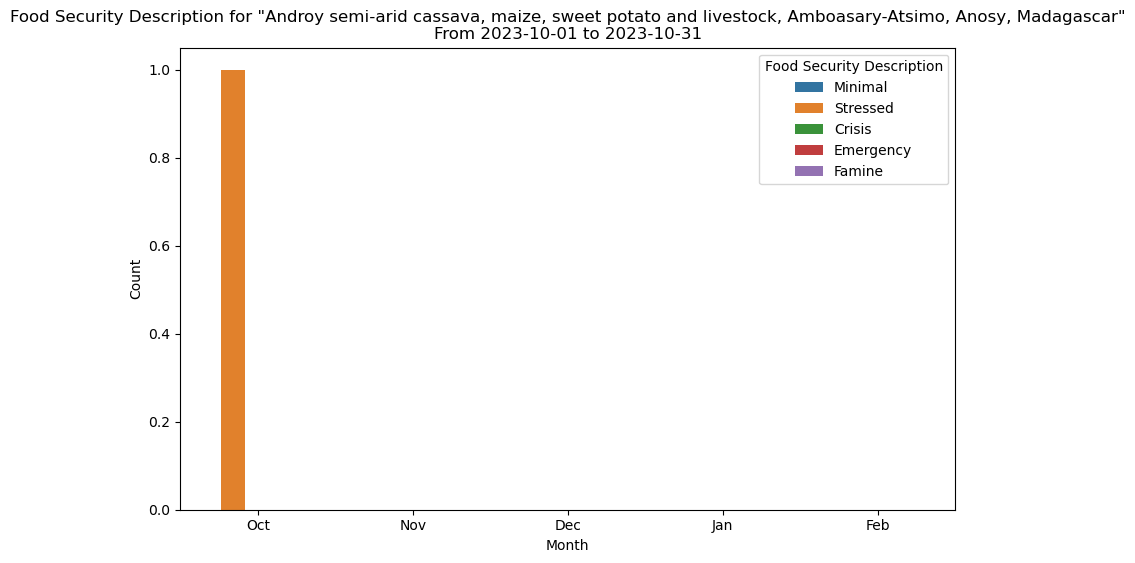

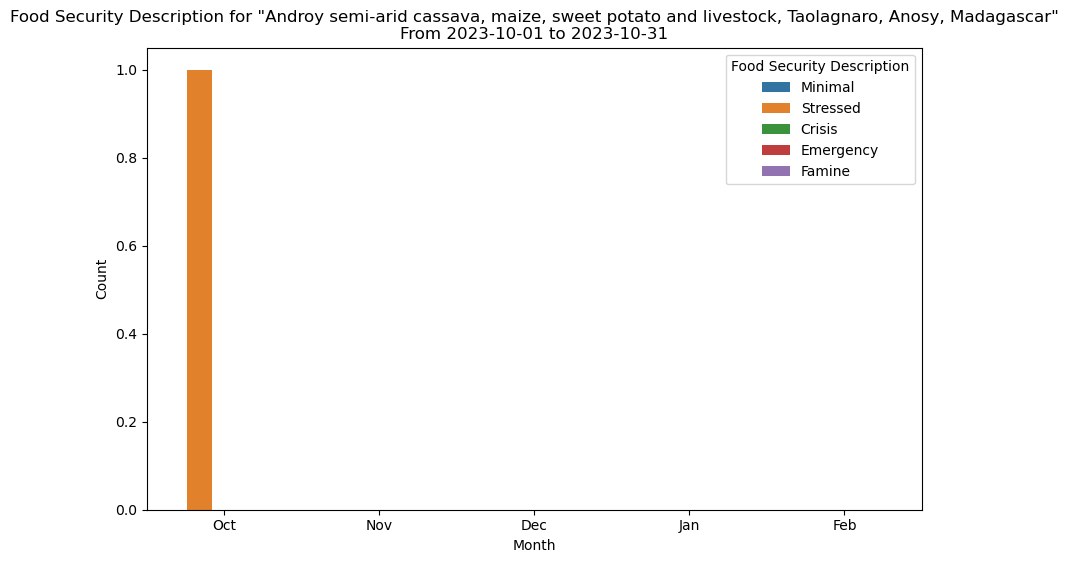

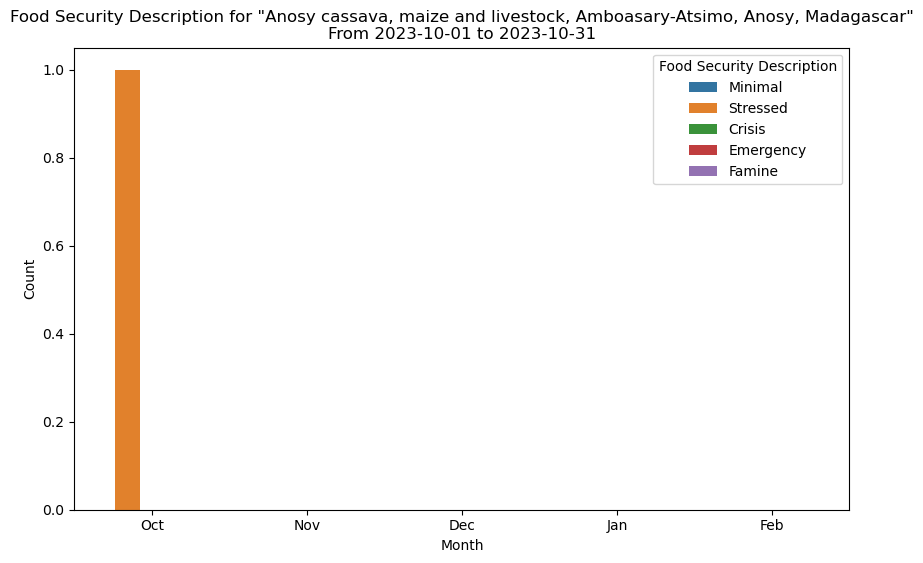

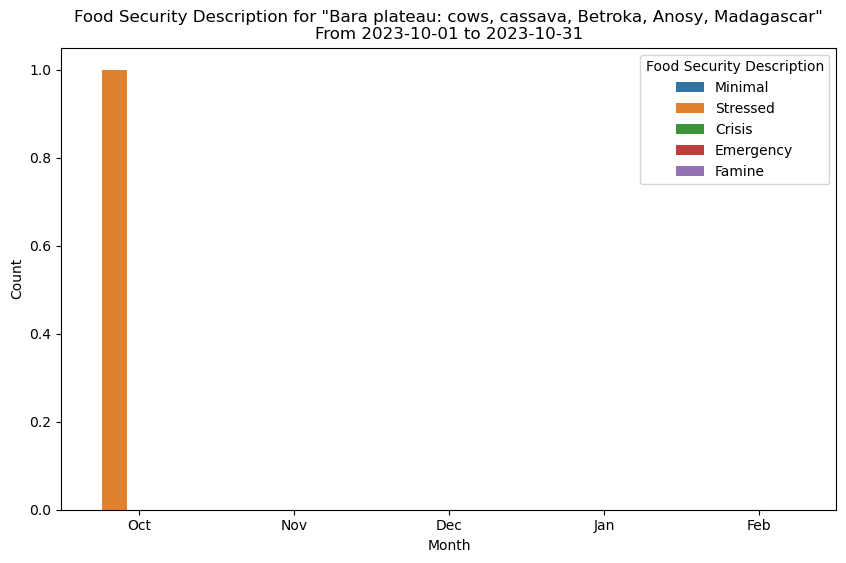

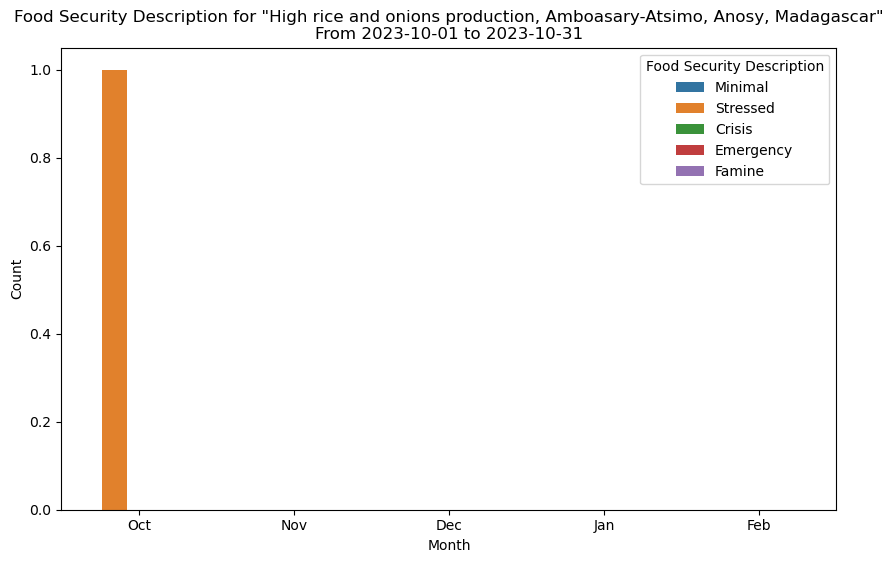

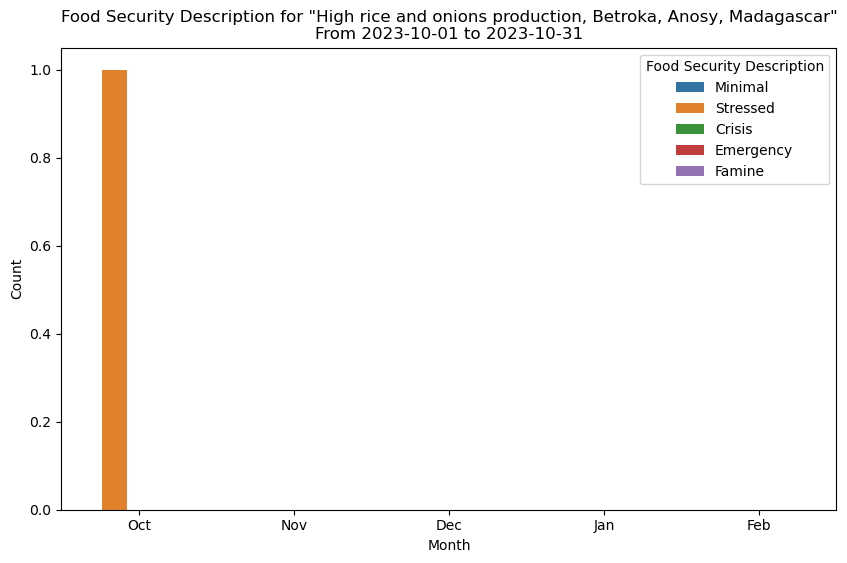

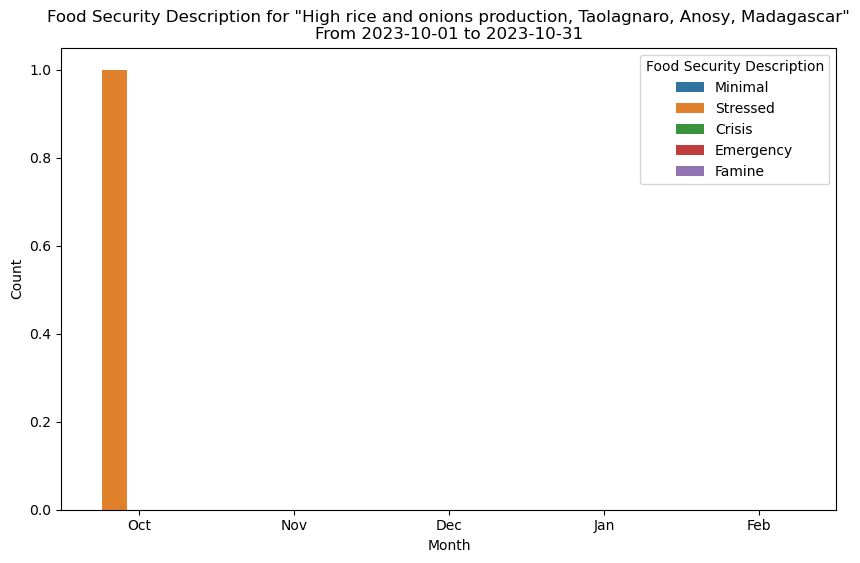

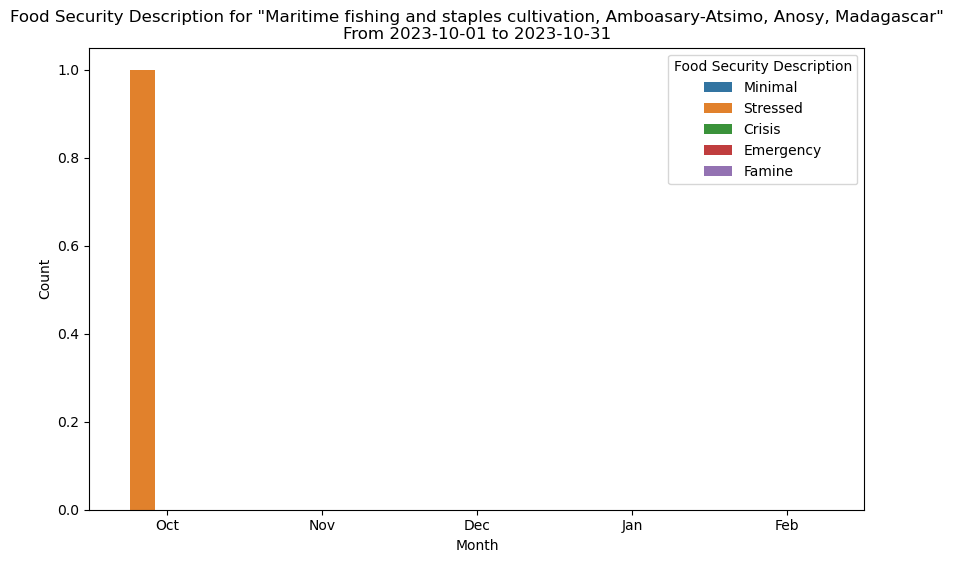

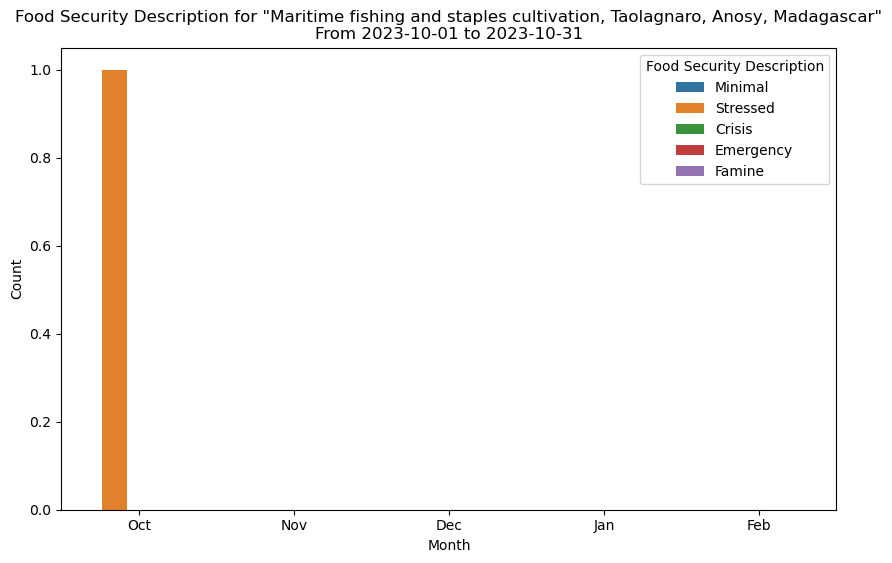

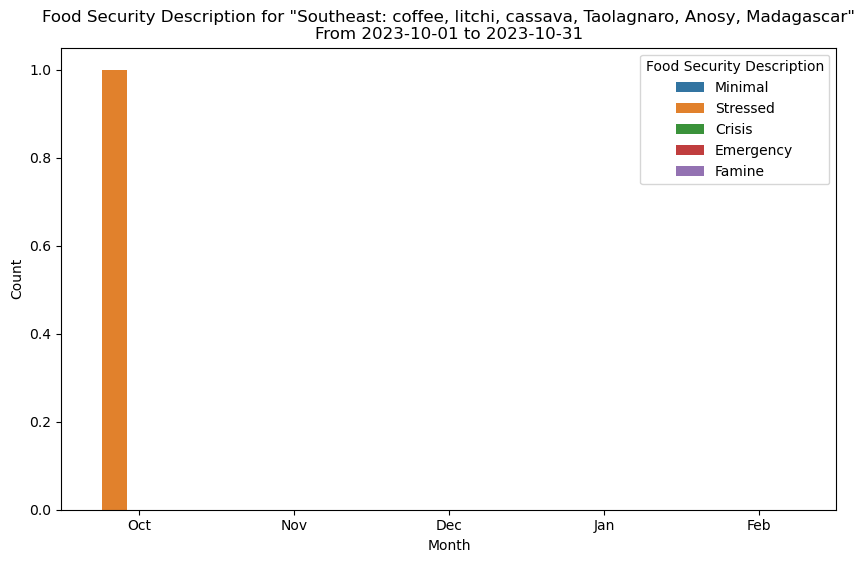

In [70]:
# Convert 'projection_start_month' to string for clearer plotting
anosy['projection_start_month_str'] = anosy['projection_start_month'].map({10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb'})


# Iterate through each unique geographic unit
for unit in anosy['geographic_unit_full_name'].unique():
    # Filter data for the current geographic unit
    unit_data = anosy[anosy['geographic_unit_full_name'] == unit]
    
    # Iterate through each unique date combination for the current geographic unit
    for _, (start_date, end_date) in unique_date_combinations.iterrows():
        # Filter data for the current date range
        date_range_data = unit_data[(unit_data['projection_start'] == start_date) & (unit_data['projection_end'] == end_date)]
        
        # Check if there is data for the current combination to avoid empty plots
        if not date_range_data.empty:
            # Create a plot for this date range
            plt.figure(figsize=(10, 6))
            sns.countplot(data=date_range_data, x='projection_start_month_str', hue='description', order=['Oct', 'Nov', 'Dec', 'Jan', 'Feb'])
            plt.title(f'Food Security Description for "{unit}"\nFrom {start_date.date()} to {end_date.date()}')
            plt.xlabel('Month')
            plt.ylabel('Count')
            plt.legend(title='Food Security Description', loc='upper right')
            plt.show()

In [ ]:
# Convert 'projection_start_month' to string for clearer plotting
anosy['projection_start_month_str'] = anosy['projection_start_month'].map({10: 'Oct', 11: 'Nov', 12: 'Dec', 1: 'Jan', 2: 'Feb'})

# Create a composite variable combining 'description' and 'is_allowing_for_assistance' for clearer legends
anosy['description_assistance'] = anosy.apply(lambda x: f"{x['description']} - {'Assistance' if x['is_allowing_for_assistance'] else 'No Assistance'}", axis=1)

# Prepare the FacetGrid plotting
g = sns.FacetGrid(anosy, col="geographic_unit_full_name", hue="description_assistance", col_wrap=3, height=4, aspect=1.5)
g.map(sns.countplot, "projection_start_month_str", order=['Oct', 'Nov', 'Dec', 'Jan', 'Feb'], alpha=0.7)

# Add titles and adjust legend
g.add_legend(title='Food Security & Assistance')
g.set_axis_labels("Month", "Count")
g.set_titles("{col_name}")

# Adjust the layout
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Food Security Descriptions and Assistance by Geographic Unit and Month')

# Show the plot
plt.show()

In [40]:
# Attempting the operation again with correct syntax and approach
anosy_grouped = df[df['region'] == 'Anosy'].groupby(['geographic_unit_full_name', 'is_allowing_for_assistance', 'description']).size().unstack(fill_value=0)

anosy_grouped

description                                                                    Minimal  \
geographic_unit_full_name                          is_allowing_for_assistance            
Androy semi-arid cassava, maize, sweet potato a... False                             0   
                                                   True                              0   
Androy semi-arid cassava, maize, sweet potato a... False                             0   
                                                   True                              0   
Anosy cassava, maize and livestock, Amboasary-A... False                             0   
                                                   True                              0   
Bara plateau: cows, cassava, Betroka, Anosy, Ma... False                             0   
                                                   True                              0   
High rice and onions production, Amboasary-Atsi... False                             0   
                                                   True                              0   
High rice and onions production, Betroka, Anosy... False                             0   
                                                   True                              0   
High rice and onions production, Taolagnaro, An... False                             0   
                                                   True                              0   
Maritime fishing and staples cultivation, Amboa... False                             0   
                                                   True                              0   
Maritime fishing and staples cultivation, Taola... False                             0   
                                                   True                              0   
Southeast: coffee, litchi, cassava, Taolagnaro,... False                             0   
                                                   True                              0   

description                                                                    Stressed  \
geographic_unit_full_name                          is_allowing_for_assistance             
Androy semi-arid cassava, maize, sweet potato a... False                              1   
                                                   True                               1   
Androy semi-arid cassava, maize, sweet potato a... False                              2   
                                                   True                               0   
Anosy cassava, maize and livestock, Amboasary-A... False                              1   
                                                   True                               1   
Bara plateau: cows, cassava, Betroka, Anosy, Ma... False                              2   
                                                   True                               0   
High rice and onions production, Amboasary-Atsi... False                              1   
                                                   True                               1   
High rice and onions production, Betroka, Anosy... False                              2   
                                                   True                               0   
High rice and onions production, Taolagnaro, An... False                              2   
                                                   True                               0   
Maritime fishing and staples cultivation, Amboa... False                              2   
                                                   True                               0   
Maritime fishing and staples cultivation, Taola... False                              2   
                                                   True                               0   
Southeast: coffee, litchi, cassava, Taolagnaro,... False                              2   
                                                   True                               0   

description     

In [ ]:
# To address the request, we'll write a loop that goes through each 'geographic_unit_full_name' within the dataset,
# and creates a graph for each unit showing the food security description across the specified months of interest.

# We'll assume 'df' is the filtered dataset containing the relevant columns and data.

# Get unique 'geographic_unit_full_name' values to iterate over
unique_geographic_units = df['geographic_unit_full_name'].unique()

# Initialize a figure for plotting multiple subplots. The number of rows is determined by the number of unique geographic units.
fig, axs = plt.subplots(nrows=len(unique_geographic_units), figsize=(12, 6*len(unique_geographic_units)))

# Check if there's only one subplot to handle the case where axs is not an array
if len(unique_geographic_units) == 1:
    axs = [axs]

# Loop through each unique geographic unit and create a graph
for i, unit in enumerate(unique_geographic_units):
    # Filter data for the current geographic unit
    unit_data = df[df['geographic_unit_full_name'] == unit]

    # Plotting
    sns.countplot(data=unit_data, x='projection_start_month', hue='description', order=months_of_interest, ax=axs[i])
    axs[i].set_title(f'Food Security Description for {unit}')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Food Security Description', loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
#Appendix

# Identify object type columns in the filtered DataFrame
object_columns = df.select_dtypes(include=['object']).columns

# Print unique values for each object type column
unique_values_object_columns = {col: df[col].unique() for col in object_columns}

unique_values_object_columns